# Check mining polygons

In [1]:
import geopandas as gpd
import shapely
import leafmap.foliumap as leafmap
import rasterio
from shapely.geometry import box
import pandas as pd

# # optional change working directiory first
import os
print(os.getcwd())
os.chdir("..")
print(os.getcwd())


import sys
sys.path.append('..')

from src.data.get_satellite_images import ReadSTAC

/workspaces/mine-segmentation/notebooks
/workspaces/mine-segmentation


In [15]:
# download mining polygons
import os
parend_dir = os.path.dirname(os.getcwd())
script_path = os.path.join(parend_dir, 'src', 'data', 'get_mining_polygons.py')
os.system(f'python {script_path}')

python: can't open file '/workspaces/src/data/get_mining_polygons.py': [Errno 2] No such file or directory


512

In [2]:
MAUS_POLYGONS = "data/external/maus_mining_polygons.gpkg"
MAUS_AREA_RASTER = "data/external/maus_mining_raster.tif"
TANG_POLYGONS = "data/external/tang_mining_polygons/74548_mine_polygons/74548_projected.shp"

# filter both dataframes to only the area of interest
LOCATION = [-50.16556135114535, -6.060451692157381]
BBOX = [LOCATION[0] - 0.5, LOCATION[1] - 0.5, LOCATION[0] + 0.5, LOCATION[1] + 0.5]


In [3]:
# Load a GeoPackage file into a GeoDataFrame
maus_gdf = gpd.read_file(MAUS_POLYGONS)

# Load a Shapefile into a GeoDataFrame
tang_gdf = gpd.read_file(TANG_POLYGONS)

In [18]:
maus_gdf.head()

,ISO3_CODE,COUNTRY_NAME,AREA,geometry
0,GBR,United Kingdom,1.782044,"POLYGON ((-1.67130 55.07660, -1.67040 55.07710..."
1,FJI,Fiji,0.023405,"POLYGON ((177.85480 -17.51730, 177.85490 -17.5..."
2,NZL,New Zealand,0.042758,"POLYGON ((175.87200 -37.34490, 175.87180 -37.3..."
3,FJI,Fiji,0.248552,"POLYGON ((177.84260 -17.51850, 177.84370 -17.5..."
4,FJI,Fiji,0.132724,"POLYGON ((177.84950 -17.49510, 177.84920 -17.4..."


In [19]:
tang_gdf.head()

,OBJECTID,Name,Shape_Le_1,Shape_Area,geometry
0,1,Au,507.731122,1.213696e+04,"POLYGON Z ((9746741.997 3480087.392 0.000, 974..."
1,2,Au,22248.346547,6.566996e+06,"POLYGON Z ((10362412.948 5571579.856 0.000, 10..."
2,3,Au,19467.203319,7.109258e+06,"POLYGON Z ((-6976558.709 -1779192.275 0.000, -..."
3,4,Fe,8281.186849,2.323061e+06,"POLYGON Z ((11034240.023 5539946.449 0.000, 11..."
4,5,0,1492.049584,1.231474e+05,"POLYGON Z ((8889342.751 3577269.676 0.000, 888..."


In [20]:
print(maus_gdf.shape)
print(tang_gdf.shape)

(44929, 4)
(74548, 5)


In [21]:
# check how many empty geometries are in the tang_gdf
empty_geometries = tang_gdf[tang_gdf.geometry == None]
len(empty_geometries)

0

In [22]:
# convert projected coordinates in tang to lat long
tang_gdf = tang_gdf.to_crs(epsg=4326)

In [23]:
# Flatten polygon dimensions from 3D to 2D
tang_gdf.geometry = shapely.wkb.loads(shapely.wkb.dumps(tang_gdf.geometry, output_dimension=2))

In [24]:
maus_gdf_filtered = maus_gdf.cx[BBOX[0]:BBOX[2], BBOX[1]:BBOX[3]]
tang_gdf_filtered = tang_gdf.cx[BBOX[0]:BBOX[2], BBOX[1]:BBOX[3]]

In [25]:
maus_gdf_filtered.iloc[0,:].geometry.bounds

(-50.342299999999994, -6.4754000000000005, -50.3121, -6.440400000000001)

In [26]:
maus_gdf_filtered.head()

,ISO3_CODE,COUNTRY_NAME,AREA,geometry
4308,BRA,Brazil,4.526153,"POLYGON ((-50.34230 -6.46640, -50.33970 -6.470..."
4316,BRA,Brazil,4.029746,"POLYGON ((-50.23900 -6.43630, -50.24980 -6.441..."
4329,BRA,Brazil,0.363408,"POLYGON ((-49.87660 -6.20440, -49.87830 -6.208..."
4334,BRA,Brazil,1.585674,"POLYGON ((-50.00340 -6.11420, -50.00800 -6.115..."
4339,BRA,Brazil,0.826450,"POLYGON ((-49.75480 -6.23760, -49.75770 -6.242..."


In [27]:
tang_gdf_filtered.head()

,OBJECTID,Name,Shape_Le_1,Shape_Area,geometry
7687,7688,Placemark,6284.211434,1.395161e+06,"POLYGON ((-50.58005 -6.05403, -50.58030 -6.051..."
7688,7689,Placemark,11521.144792,2.317360e+06,"POLYGON ((-50.57555 -6.02529, -50.57362 -6.025..."
7689,7690,Placemark,17145.217793,8.213193e+06,"POLYGON ((-50.53541 -5.78219, -50.53166 -5.782..."
7690,7691,Placemark,26207.278720,4.201798e+06,"POLYGON ((-50.51591 -5.76025, -50.51560 -5.760..."
7692,7693,Placemark,10317.859600,1.552590e+06,"POLYGON ((-50.30800 -6.10007, -50.30730 -6.100..."


In [15]:
# Create a Leaflet map
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)
m.add_basemap("satellite")


style = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
    "fillOpacity": 0.1,
}

# Add the GeoDataFrame to the map
m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")
m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)

# Display the map
m

Basemap can only be one of the following: OpenStreetMap, ROADMAP, SATELLITE, TERRAIN, HYBRID, FWS NWI Wetlands, FWS NWI Wetlands Raster, NLCD 2021 CONUS Land Cover, NLCD 2019 CONUS Land Cover, NLCD 2016 CONUS Land Cover, NLCD 2013 CONUS Land Cover, NLCD 2011 CONUS Land Cover, NLCD 2008 CONUS Land Cover, NLCD 2006 CONUS Land Cover, NLCD 2004 CONUS Land Cover, NLCD 2001 CONUS Land Cover, USGS NAIP Imagery, USGS NAIP Imagery False Color, USGS NAIP Imagery NDVI, USGS Hydrography, USGS 3DEP Elevation, ESA WorldCover 2020, ESA WorldCover 2020 S2 FCC, ESA WorldCover 2020 S2 TCC, ESA WorldCover 2021, ESA WorldCover 2021 S2 FCC, ESA WorldCover 2021 S2 TCC, BaseMapDE.Color, BaseMapDE.Grey, BasemapAT.basemap, BasemapAT.grau, BasemapAT.highdpi, BasemapAT.orthofoto, BasemapAT.overlay, BasemapAT.surface, BasemapAT.terrain, CartoDB.DarkMatter, CartoDB.DarkMatterNoLabels, CartoDB.DarkMatterOnlyLabels, CartoDB.Positron, CartoDB.PositronNoLabels, CartoDB.PositronOnlyLabels, CartoDB.Voyager, CartoDB.Voya

# Overlay a Sentinel Image with the mining polygons

In [46]:
# Download the image 
# Option 1 (Default): Read from Planetary Computer STAC API
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']
bands_landsat = ['red', 'green', 'blue']

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

# check available items
items = stac_reader.get_items(
    location = (-59.66666666666667, 7.33333333333334 ),
    buffer=10,
    timerange='2020-01-01/2020-12-30',
    max_cloud_cover=10
)

0 Items found.


## Start with only displaying a small Area of Interest

In [17]:
stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
stack_stretched = stac_reader.stretch_contrast_stack(stack, upper_percentile=1.0, lower_percentile=0.0)
image = stac_reader.save_stack_as_geotiff(stack_stretched, filename="sentinel_image.tif")

Loading stack...
Found 2 unique tile ids.
Choosing the best 1 items.For unique tile 22MEU, choosing ['S2A_MSIL2A_20200614T134221_R124_T22MEU_20200827T082613'] from [datetime.date(2020, 6, 14)] with [0.008988]% cloud cover
Choosing the best 1 items.For unique tile 22MFU, choosing ['S2B_MSIL2A_20200729T134219_R124_T22MFU_20200818T015550'] from [datetime.date(2020, 7, 29)] with [0.016453]% cloud cover
Returning stack from single S2 image with ID: S2A_MSIL2A_20200614T134221_R124_T22MEU_20200827T082613
Stretching contrast...
Saving stack as GeoTIFF under: data/interim/sentinel_image.tif


In [18]:
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)

m.add_raster(image, layer_name="Image")
m

In [19]:
# add the polygons in the area
m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")
m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)
m

## Display the whole S2 Tile

In [20]:
least_cloudy_item = stac_reader.filter_item(items, filter_by="least_cloudy")

Found 2 unique tile ids.
Choosing the best 1 items.For unique tile 22MEU, choosing ['S2A_MSIL2A_20200614T134221_R124_T22MEU_20200827T082613'] from [datetime.date(2020, 6, 14)] with [0.008988]% cloud cover
Choosing the best 1 items.For unique tile 22MFU, choosing ['S2B_MSIL2A_20200729T134219_R124_T22MFU_20200818T015550'] from [datetime.date(2020, 7, 29)] with [0.016453]% cloud cover


In [21]:
m = stac_reader.preview_tile_outlines(least_cloudy_item)
m

Map(center=[-6.060451692157381, -50.16556135114535], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Test global MGRS 10x10 km grid and overlay it with mining polygons

In [7]:
# read the mgrs shapefile
mgrs_gdf = gpd.read_file("data/external/mgrs_index_ftp_link/mgrs_index_ftp_link.shp")

In [20]:
from shapely.geometry import Polygon
import pyproj
from shapely.ops import transform
from functools import partial

def calculate_dimensions_km(polygon):
    """
    Calculate the dimensions (width, height) in kilometers of a given polygon.
    
    Parameters:
    - polygon: A shapely Polygon object.
    
    Returns:
    - A tuple (width_km, height_km) representing the dimensions in kilometers.
    """
    # Define the projection to UTM (Universal Transverse Mercator)
    # Find UTM zone for the centroid of the polygon for more accuracy
    utm_zone = int((polygon.centroid.x + 180) / 6) + 1
    crs_proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84', preserve_units=False)
    
    # Define transformations from WGS84 to UTM and back
    project_to_utm = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'), crs_proj)
    project_to_wgs84 = partial(pyproj.transform, crs_proj, pyproj.Proj(init='epsg:4326'))
    
    # Transform the polygon to the UTM projection
    polygon_utm = transform(project_to_utm, polygon)
    
    # Calculate bounds in UTM
    minx, miny, maxx, maxy = polygon_utm.bounds
    
    # Calculate width and height in meters
    width_m = maxx - minx
    height_m = maxy - miny
    
    # Convert meters to kilometers
    width_km = width_m / 1000
    height_km = height_m / 1000
    
    return (width_km, height_km)

# Example usage
polygon = mgrs_gdf.iloc[0].geometry
width_km, height_km = calculate_dimensions_km(polygon)
print(f"Width: {width_km} km, Height: {height_km} km")

Width: 206.86611291912214 km, Height: 894.1524540288196 km


In [ ]:
mgrs_gdf.iloc[0:2,:].geometry

# add that on a map
m = leafmap.Map()
m.add_gdf(mgrs_gdf.iloc[0:2,:], layer_name="mgrs_gdf")
m

# Load Raster for mining areas from Maus et al

In [22]:
# Load the raster for mining areas 
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)
m.add_raster(MAUS_AREA_RASTER, layer_name="Mining Areas", alpha=0.5)

# Display the map
m

In [101]:
def resample_geotiff(source_path, dest_path, resampling_factor): 
    import rasterio
    from rasterio.enums import Resampling

    with rasterio.open(source_path) as dataset:

        # resample data to target shape using upscale_factor
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * resampling_factor),
                int(dataset.width * resampling_factor)
            ),
            resampling=Resampling.average
        )

        print('Shape before resample:', dataset.shape)
        print('Shape after resample:', data.shape[1:])

        # scale image transform
        dst_transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

        print('Transform before resample:\n', dataset.transform, '\n')
        print('Transform after resample:\n', dst_transform)

        # Write outputs
        # set properties for output
        dst_kwargs = dataset.meta.copy()
        dst_kwargs.update(
            {
                "crs": dataset.crs,
                "transform": dst_transform,
                "width": data.shape[-1],
                "height": data.shape[-2],
                "nodata": 0,  
            }
        )

        with rasterio.open(dest_path, "w", **dst_kwargs) as dst:
            # iterate through bands
            for i in range(data.shape[0]):
                dst.write(data[i].astype(rasterio.uint32), i+1)

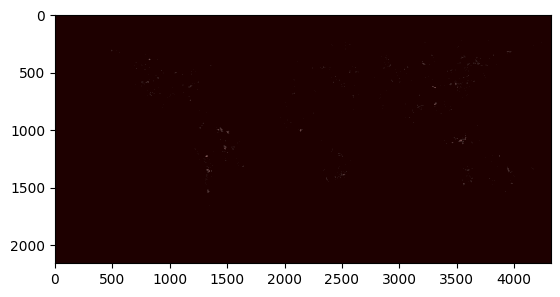

In [11]:
from matplotlib import pyplot
import rasterio
array = rasterio.open(MAUS_AREA_RASTER).read(1)

# set everything smaller than 0 to 0
array = array.clip(0)

pyplot.imshow(array, cmap='pink')
pyplot.show()

In [97]:
import numpy as np
from tqdm import tqdm
src = rasterio.open("test.tif")
array = src.read(1)

# Get the transformation matrix
transform = src.transform

# Create an empty list to store the bounding boxes
bounding_boxes = []
mining_area = []

# Iterate over the pixels in the raster
# only record bounding box if they have over 0.5 square km of mining area (out of a total area per square of 78.41 sq.km)
for x in tqdm(range(src.width)):
    for y in range(src.height):
        if array[y, x] > 0.5:
            # Get the pixel's bounding box
            # The bounding box is defined by the pixel's top-left and bottom-right corners
            top_left = transform * (x, y)
            bottom_right = transform * (x + 1, y + 1)
            bounding_box = [top_left[0], bottom_right[1], bottom_right[0], top_left[1]]
            
            # Add the bounding box to the list
            bounding_boxes.append(bounding_box)

            # add the mining area to the list
            mining_area.append(array[y, x])


100%|██████████| 432/432 [00:00<00:00, 4626.44it/s]


In [98]:
len(bounding_boxes)

203

In [99]:
# Create a GeoDataFrame from the bounding boxes and the area
gdf = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bounding_boxes], crs="EPSG:4326")
gdf["mining_area"] = mining_area
gdf

,geometry,mining_area
0,"POLYGON ((-138.33333 63.33333, -138.33333 64.1...",1.0
1,"POLYGON ((-116.66667 40.00000, -116.66667 40.8...",1.0
2,"POLYGON ((-113.33333 40.83333, -113.33333 41.6...",1.0
3,"POLYGON ((-113.33333 40.00000, -113.33333 40.8...",1.0
4,"POLYGON ((-112.50000 40.83333, -112.50000 41.6...",2.0
...,...,...
198,"POLYGON ((150.00000 62.50000, 150.00000 63.333...",1.0
199,"POLYGON ((150.83333 62.50000, 150.83333 63.333...",1.0
200,"POLYGON ((151.66667 -32.50000, 151.66667 -31.6...",1.0
201,"POLYGON ((151.66667 -33.33333, 151.66667 -32.5...",1.0


In [95]:
# Create a Map
m = leafmap.Map(center=[(bounding_boxes[0][1] + bounding_boxes[0][3]) / 2, 
                        (bounding_boxes[0][0] + bounding_boxes[0][2]) / 2], zoom=2)

# Add the GeoDataFrame to the map
m.add_gdf(gdf, layer_name="bounding_boxes")

# Display the map
m

In [34]:
# save the bounding boxes as a geopackage file
gdf.to_file("/workspaces/mine-segmentation/data/interim/mining_areas.gpkg", driver="GPKG")

# Sample random mining tile, plot 2019 sentinel image, and add both mining datasets to it. 

In [7]:
# read gdf
gdf = gpd.read_file("/workspaces/mine-segmentation/data/interim/mining_areas.gpkg")

In [8]:
import random

# Set the random seed for reproducibility
random.seed(1234)

In [9]:

YEAR = 2019

# Sample a random mining tile
random_tile = gdf.sample(n=1, random_state=random.randint(0, 100))

# Get the geometry of the random tile
tile_geometry = random_tile['geometry'].values[0]

bbox = tile_geometry.bounds

api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

# get the least cloudy sentinel image for the tile
items = stac_reader.get_items(
    bbox=bbox,
    timerange=f'{YEAR}-01-01/{YEAR}-12-31',
    max_cloud_cover=10
)

stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
stack_stretched = stac_reader.stretch_contrast_stack(stack, upper_percentile=0.99, lower_percentile=0.01)
image = stac_reader.save_stack_as_geotiff(stack_stretched, filename="sentinel_image.tif")

# Create a Map
m = leafmap.Map(center=[tile_geometry.centroid.y, tile_geometry.centroid.x], zoom=2)

# add the image
m.add_raster(image)

# Filter the polygons that are included 
maus_gdf_filtered = maus_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
tang_gdf_filtered = tang_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

style = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
    "fillOpacity": 0.1,
}

# Display the filtered gdfs
if not maus_gdf_filtered.empty:
    m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")

if not tang_gdf_filtered.empty:
    m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)

m

4 Items found.
Loading stack...
Found 1 unique tile ids.
Choosing the best 1 items.For unique tile 48RXR, choosing ['S2A_MSIL2A_20190812T032541_R018_T48RXR_20201004T232107'] from [datetime.date(2019, 8, 12)] with [0.405742]% cloud cover


UnboundLocalError: cannot access local variable 'stack' where it is not associated with a value

In [27]:
# load mining areas
mining_areas = gpd.read_file("/workspaces/mine-segmentation/data/interim/mining_areas.gpkg")

# get the tile number 4,242
tile = mining_areas.iloc[4242:4244, :]

# plot that tile on a map
m = leafmap.Map(zoom=10)
m.add_gdf(tile, layer_name="tile")
m



In [35]:
print(tile.iloc[0,:].geometry)

POLYGON ((-59.66666666666667 7.333333333333343, -59.66666666666667 7.416666666666671, -59.75 7.416666666666671, -59.75 7.333333333333343, -59.66666666666667 7.333333333333343))
